In [1]:
import pandas as pd
from tqdm import tqdm
import time
from collections import Counter as ctr

In [2]:
train = pd.read_csv("train.txt", delimiter=" ", names=['word', 'tag', 'drop']).drop('drop', axis=1)
tags = train['tag'].unique()
smoother = float(1e-5)
total = len(train)

### Emission Function $P(T_i|W_{i-1})$

In [22]:
word_tag_counts = {}
word_tag_totals = {}

for tag in tags:
    sub_train = train[train['tag']==tag]
    word_tag_counts[tag] = ctr(sub_train['word'])
    word_tag_totals[tag] = sum(word_tag_counts[tag].values())

#P(W|T)
def Pwt(W='', T=''):
    if W not in word_tag_counts[T]:
        return smoother
    return word_tag_counts[T][W] / word_tag_totals[T]
#P(T)
tag_counts = ctr(train['tag'])
def Ptag(T=''):
    return tag_counts[T] / total
#P(W)
word_counts = ctr(train['word'])
def Pword(W=''):
    if W not in word_counts:
        return smoother
    return word_counts[W] / total
#P(T|W)
def Pemmission(T='', W=''):
    return (Pwt(W=W, T=T) * Ptag(T)) / Pword(W)

### Transition Function $P(T_i|T_{i-1})$

In [4]:
train['prev_tag'] = train['tag'].shift(1)
train = train.dropna()

In [5]:
tag_bigram_counts = {}

for tag in tags:
    sub_train = train[train['tag']==tag]
    tag_bigram_counts[tag] = ctr(sub_train['prev_tag'])

In [65]:
# P(T_i|T{i-1})
def Ptransition(tag='', ptag=''):
    # Account for first iteration
    if ptag == None:
        return smoother
    return tag_bigram_counts[tag][ptag] / word_tag_totals[ptag]

### Greedy Decoder

In [72]:
def greedy_decoder(df):
    guesses = []
    ptag = None
    for w in tqdm(df['word']):
        transition_emission = {}
        tag_probs = {t:Pemmission(T=t, W=w) * Ptransition(tag=t, ptag=ptag) for t in tags}
        max_tag = max(tag_probs, key=tag_probs.get)
        guesses.append(max_tag)
        ptag = max_tag
    return guesses

In [73]:
guesses = greedy_decoder(train)

100%|██████████| 211722/211722 [00:04<00:00, 48679.62it/s]


In [74]:
train['guesses'] = guesses
print(sum(train['tag'] == train['guesses']) / len(train))

0.9526407269910543


### Load Test Data

In [75]:
test = pd.read_csv("test.txt", delimiter=" ", names=['word', 'tag', 'drop']).drop('drop', axis=1)

In [76]:
test_guesses = greedy_decoder(test)

100%|██████████| 47377/47377 [00:01<00:00, 46181.60it/s]


In [77]:
test['guesses'] = test_guesses
print(sum(test['tag'] == test['guesses']) / len(test))

0.9039829453110159


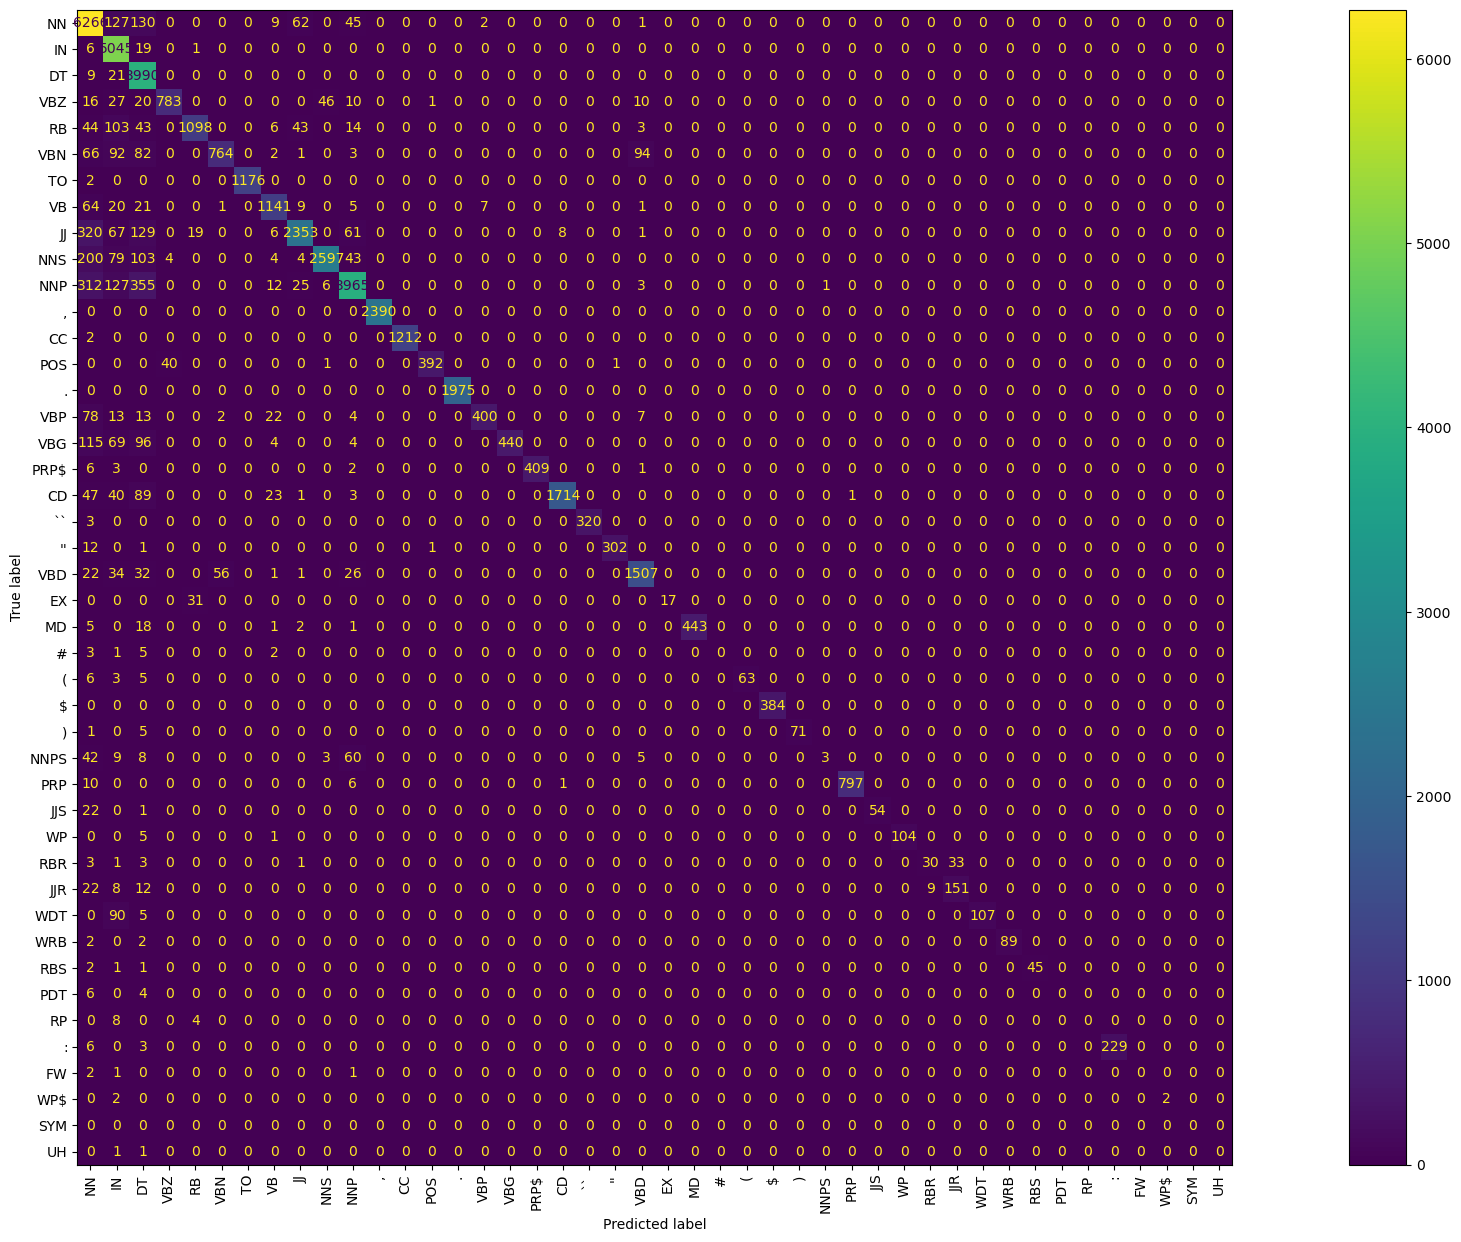

In [113]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test['tag'], test['guesses'], labels=tags)
fig, ax = plt.subplots(figsize=(30, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tags)
disp.plot(ax=ax)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)

# Show plot
plt.show()

Some common errors that my tagger is making include guessing NN when it's actually NNP, NN when it's JJ, IN when it's NN, DT when it's NNP, and : when it's RP (which is strange)